# Settings

In [1]:
# import modules 
%matplotlib inline
from os.path import join as opj
import nipype.interfaces.afni as afni 
import nipype.interfaces.spm as spm
from nipype.interfaces.spm import Realign
from nipype.interfaces.utility import Function, IdentityInterface
import nipype.algorithms.misc as misc
from nipype.interfaces.io import FreeSurferSource, SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype.algorithms.misc import Gunzip
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.ants import Registration, ApplyTransforms
from nipype.interfaces.freesurfer import (FSCommand, MRIConvert)
import nipype.interfaces.fsl as fsl         # fsl
import nipype.interfaces.freesurfer as fs   # freesurfer
import nipype.interfaces.io as nio          # i/o routines
import nipype.interfaces.utility as util    # utility
from nipype.interfaces.c3 import C3dAffineTool
import nipype.pipeline.engine as pe  # pypeline engine


/home/lmn/install/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# SPM
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/home/lmn/spm12/') # set the path to your local spm folder
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

In [3]:
# FreeSurfer - Specify the location of the freesurfer folder
fs_dir = '/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/mindboggle/freesurfer_subjects' # placeholder!
FSCommand.set_default_subjects_dir(fs_dir)

# define experiment specific parameters

In [4]:
experiment_dir = '/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/' # location of experiment folder
subject_list = [] # create the subject_list variable

output_dir = 'derivatives/preprocessing/output_dir/' # name of output folder
working_dir = 'derivatives/preprocessing/working_dir/' # name of working directory

subject_list = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']


number_of_slices = 30                         # number of slices in volume
TR = 1.5                                      # time repetition of volume

fwhm = [4,6]

# Import data using SelectFiles

In [5]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': '/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/{subject_id}/func/{subject_id}_task-stress*.nii.gz',
             'aparc_aseg': '/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/mindboggle/freesurfer_subjects/{subject_id}/mri/aparc+aseg.mgz',
             'brainmask': '/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/mindboggle/freesurfer_subjects/{subject_id}/mri/brainmask.mgz',
             'ribbon': '/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/mindboggle/freesurfer_subjects/{subject_id}/mri/ribbon.mgz',
             'anat': '/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/mindboggle/freesurfer_subjects/{subject_id}/mri/brain.mgz'}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

#antsreg = 

# create nodes

In [6]:
smooth = pe.Node(interface=spm.Smooth(), name="smooth")
fwhm = [6, 4]
smooth.iterables = ('fwhm', fwhm)

# Despike node - despike data
despike = MapNode(afni.Despike(outputtype='NIFTI'),
               name='despike', iterfield=['in_file'])

# Realign - correct for motion
realign = Node(spm.Realign(register_to_mean=True),
               name="realign")

# Artifact Detection - determine which of the images in the functional series
# are outliers. This is based on deviation in intensity or movement.
art = Node(ArtifactDetect(norm_threshold=1,
                          zintensity_threshold=3,
                          mask_type='file',
                          parameter_source='SPM',
                          use_differences=[True, False]),
           name="art")

# Gunzip - unzip functional
gunzip = MapNode(misc.Gunzip(), name="gunzip", iterfield=['in_file'])

# MRIConvert - to unzip output files
mriconvert_complete_mask = Node(MRIConvert(out_type='nii'),
                     name='mriconvert_complete_mask')

# FreeSurferSource - Data grabber specific for FreeSurfer data
fssource = Node(nio.FreeSurferSource(subjects_dir=fs_dir),
                run_without_submitting=True,
                name='fssource')

# Binarize Cortex node - creates a binary map of cortical voxel
binarizeCortical = Node(fs.Binarize(out_type='nii.gz',
                                    match = [3,42],
                                    binary_file='binarized_cortical.nii.gz'),
                        name='binarizeCortical')

# Binarize Subcortex node - creates a binary map of subcortical voxel
binarizeSubcortical = Node(fs.Binarize(out_type='nii.gz',
                                       match = [10,49,  # Thalamus
                                                17,53,  # Hippocampus
                                                18,54,  # Amygdala
                                                26,58,  # AccumbensArea
                                                ],
                                    binary_file='binarized_subcortical.nii.gz'),
                       name='binarizeSubcortical')

# Brainmask node - combines cortical and subcortical binary maps
wholebrainmask = Node(fsl.BinaryMaths(operation='add',
                                 args='-bin'),
                 name='wholebrainmask')

applyVolTrans_complete_mask = Node(fs.ApplyVolTransform(reg_header=True,
                                  interp='nearest'),
                name='applyVolTrans_complete_mask')

# Dilate node - dilates the binary brain mask
dilate_complete_mask = Node(fs.Binarize(dilate=1,
                          min=0.5),
              name='dilate_complete_mask')

# Binarize Dialte node - binarizes dilated mask again after transformation
binarizeDilatedCompleteMask = Node(fs.Binarize(min=0.1, binary_file='dilated_complete_mask.nii'),
                           name='binarizeDilatedCompleteMask')

# BBRegister node - register a volume to FreeSurfer's anatomy 
bbregister = Node(fs.BBRegister(init = 'fsl',
                                contrast_type = 't2',
                                out_fsl_file = True),
                  name='bbregister')




# specify functions

In [7]:
# Gets path to the aparc+aseg file
def get_aparc_aseg(files):
    for name in files:
        if 'aparc+aseg' in name:
            return name

# Gets path to the ribbon file (both hemispheres)
def get_ribbon(files):
    for name in files:
        if 'ribbon.mgz' in name:
            return name
        
# Gets path to the mask file        
def get_maskmask(file):
    return file[0]

# plot realign parameters
def plot_realign_parameters(subject_id, realigned_files):

    # Import necessary modules
    from os.path import join as opj 
    import numpy
    import matplotlib.pyplot as plt
    import glob

    experiment_dir = '/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/' # path to your experiment directory
    working_dir = 'derivatives/preprocessing/working_dir/' # path to the working directory
    
    # Load the estimated parameters
    list_realign_parameter_files=glob.glob(opj(experiment_dir, working_dir, "preproc_hoaf", "_subject_id_"+subject_id, "realign", "*.txt"))
    
        
    plot_realign_parameters=[]
    for realign_file in list_realign_parameter_files:
    
        movement=numpy.loadtxt(realign_file)
    
        plt.figure(figsize=(10,8))
        
        plt.axhline(0, color='red')
        
        # Create the plots with matplotlib
        plt.subplot(211)
        plt.title('translation')
        plt.ylabel('in mm')
        plt.plot(movement[:,0], label='x')
        plt.plot(movement[:,1], label='y')
        plt.plot(movement[:,2], label='z')
        
        plt.legend(loc='best', fancybox=True)
        
        plt.axhline(0, color='red', alpha=0.5)
        
        plt.subplot(212)
        plt.title('rotation')
        plt.ylabel('in degrees')
        plt.plot(movement[:,3], label='pitch')
        plt.plot(movement[:,4], label='roll')
        plt.plot(movement[:,5], label='yaw')
        
        plt.legend(loc='best', fancybox=True)
        
        plt.axhline(0, color='red', alpha=0.5)

        plot_realign_parameters=plt.tight_layout()
        
        plt.savefig(opj(experiment_dir, working_dir, "preproc_hoaf" "_subject_id_"+subject_id, "realign", realign_file+".png"), bbox_inches='tight')
        
    return plot_realign_parameters
    
# plot realing parameters - plot realignment parameters and save it later on
plot_realign_parameters = Node(Function(input_names=['subject_id', 'realigned_files'],
                               output_names=['plot_realign_parameters'],
                               function=plot_realign_parameters),
                      name='plot_realign_parameters')

# create and connect preprocessing workflow

In [8]:
# Create a preprocessing workflow
preproc_hoaf = Workflow(name='preproc_hoaf')
preproc_hoaf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow - aparc / ribbon mask 
preproc_hoaf.connect([(gunzip, realign, [('out_file', 'in_files')]), # send unzipped files to realignment node
                 (realign, art, [('realigned_files', 'realigned_files')]), # send realigned files to artifact detection node
                 (realign, art, [('mean_image', 'mask_file'),
                                 ('realignment_parameters',
                                  'realignment_parameters')]),
                 (realign, despike, [('realigned_files', 'in_file')]),
                 (realign, bbregister, [('mean_image', 'source_file')]),
                 (realign, plot_realign_parameters, [('realigned_files', 'realigned_files')]), # send realign files / parameters to plot realignment parameters node 

                
                 (binarizeCortical,wholebrainmask,[('binary_file','in_file')]),
                 (binarizeSubcortical,wholebrainmask,[('binary_file',
                                                   'operand_file')]), # combine aparc_aseg and ribbon files to get a whole brain mask    
                 (wholebrainmask, mriconvert_complete_mask, [('out_file', 'in_file')]), # convert whole brain mask to nifti
                 
                 (mriconvert_complete_mask, applyVolTrans_complete_mask,[('out_file','source_file')]), # transform complete mask to functional space
                 (realign, applyVolTrans_complete_mask, [('mean_image', 'target_file')]),
                 
                 (applyVolTrans_complete_mask, dilate_complete_mask, [('transformed_file', 'in_file')]), # dilate transformed whole brain mask
                 (dilate_complete_mask, binarizeDilatedCompleteMask, [('binary_file', 'in_file')]), # binarize dilated and transformed whole brain mask   
                 (despike, smooth, [('out_file', 'in_files' )]),     
                 ]) 


In [9]:
# visualize
# Create preproc output graph
preproc_hoaf.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph


180726-16:19:25,557 nipype.workflow INFO:
	 Generated workflow graph: /media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing/working_dir/preproc_hoaf/graph.png (graph2use=colored, simple_form=True).


'/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing/working_dir/preproc_hoaf/graph.png'

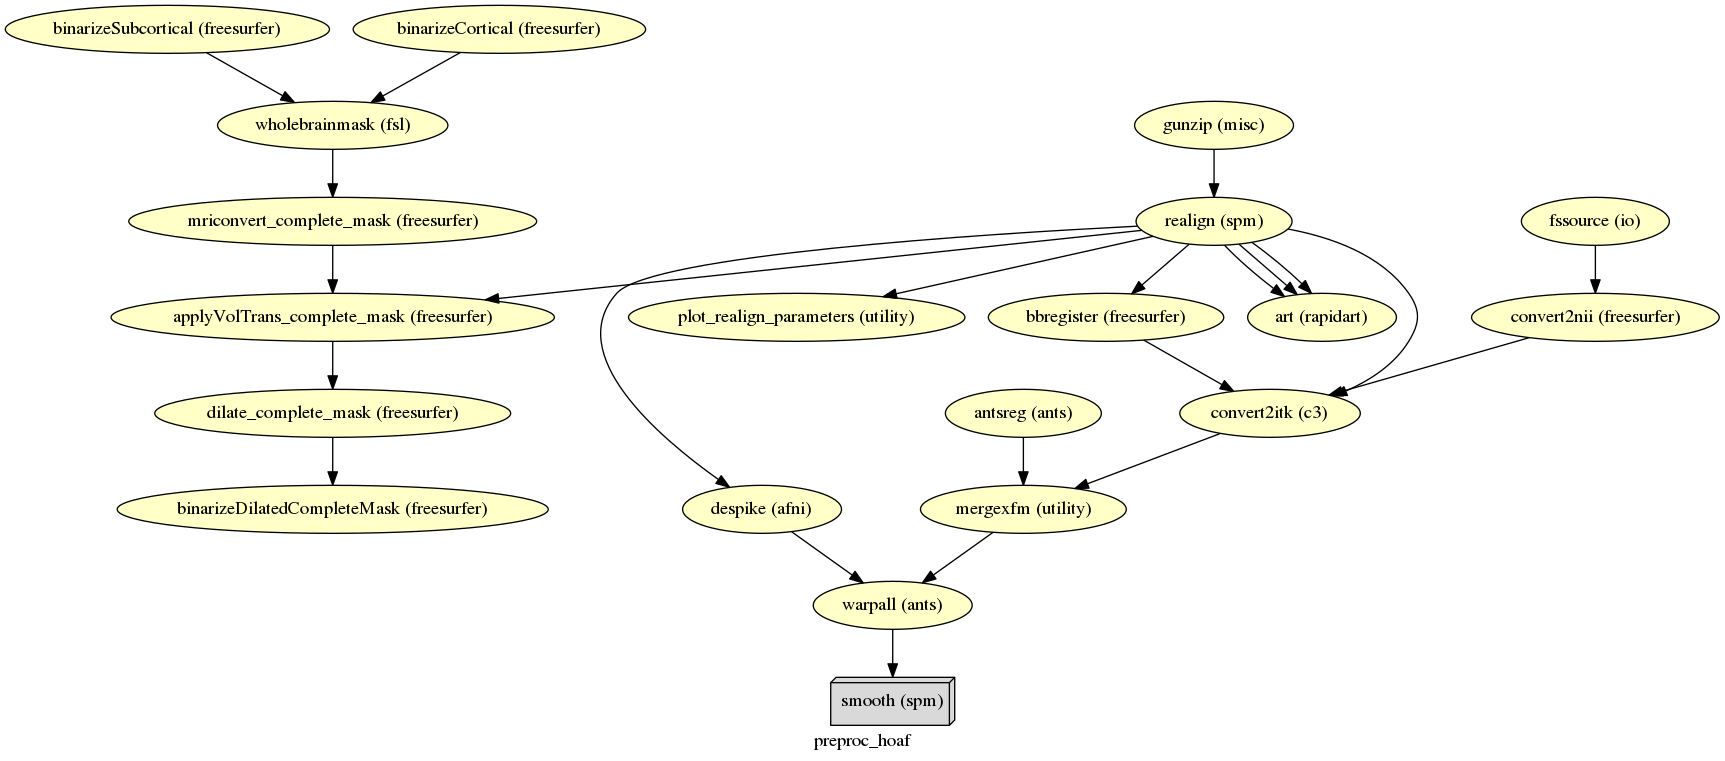

In [10]:
from IPython.display import Image
Image(filename='/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing_sub01/working_dir/preproc_hoaf/graph.png', width=750)

# Connect workflow to SelectFiles and Datasink

In [11]:
# Connect infosource, selectfiles and datasink to the preprocessing workflow
preproc_hoaf.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                  (infosource, fssource, [('subject_id',
                                          'subject_id')]),
                  (infosource, bbregister, [('subject_id',
                                          'subject_id')]), 
                  (infosource, plot_realign_parameters, [('subject_id', 'subject_id')]),		   
                  (selectfiles, gunzip, [('func', 'in_file')]),    
                  (selectfiles, binarizeSubcortical, [('aparc_aseg', 'in_file')]),
                  (selectfiles, binarizeCortical, [('ribbon', 'in_file')]),       
                  (realign, datasink, [('mean_image',
                                        'realign.@mean'),
                                       ('realignment_parameters',
                                        'realign.@parameters')]),
                  (bbregister, datasink, [('out_reg_file',
                                        'bbregister.@out_reg_file'),
                                       ('out_fsl_file',
                                        'bbregister.@out_fsl_file'),
                                       ('registered_file',
                                        'bbregister.@registered_file')]),
                  (art, datasink,     [('outlier_files',
                                        'art.@outliers'),
                                       ('plot_files',
                                        'art.@plot')]),
                  (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                  (binarizeDilatedCompleteMask, datasink, [('binary_file',      
                                        'masks.@binarized_dilated_complete_mask')]),    
                  ])

# Visualize the workflow

In [12]:
# visualize
# Create preproc output graph
preproc_hoaf.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph


180726-16:19:25,793 nipype.workflow INFO:
	 Generated workflow graph: /media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing/working_dir/preproc_hoaf/graph.png (graph2use=colored, simple_form=True).


'/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing/working_dir/preproc_hoaf/graph.png'

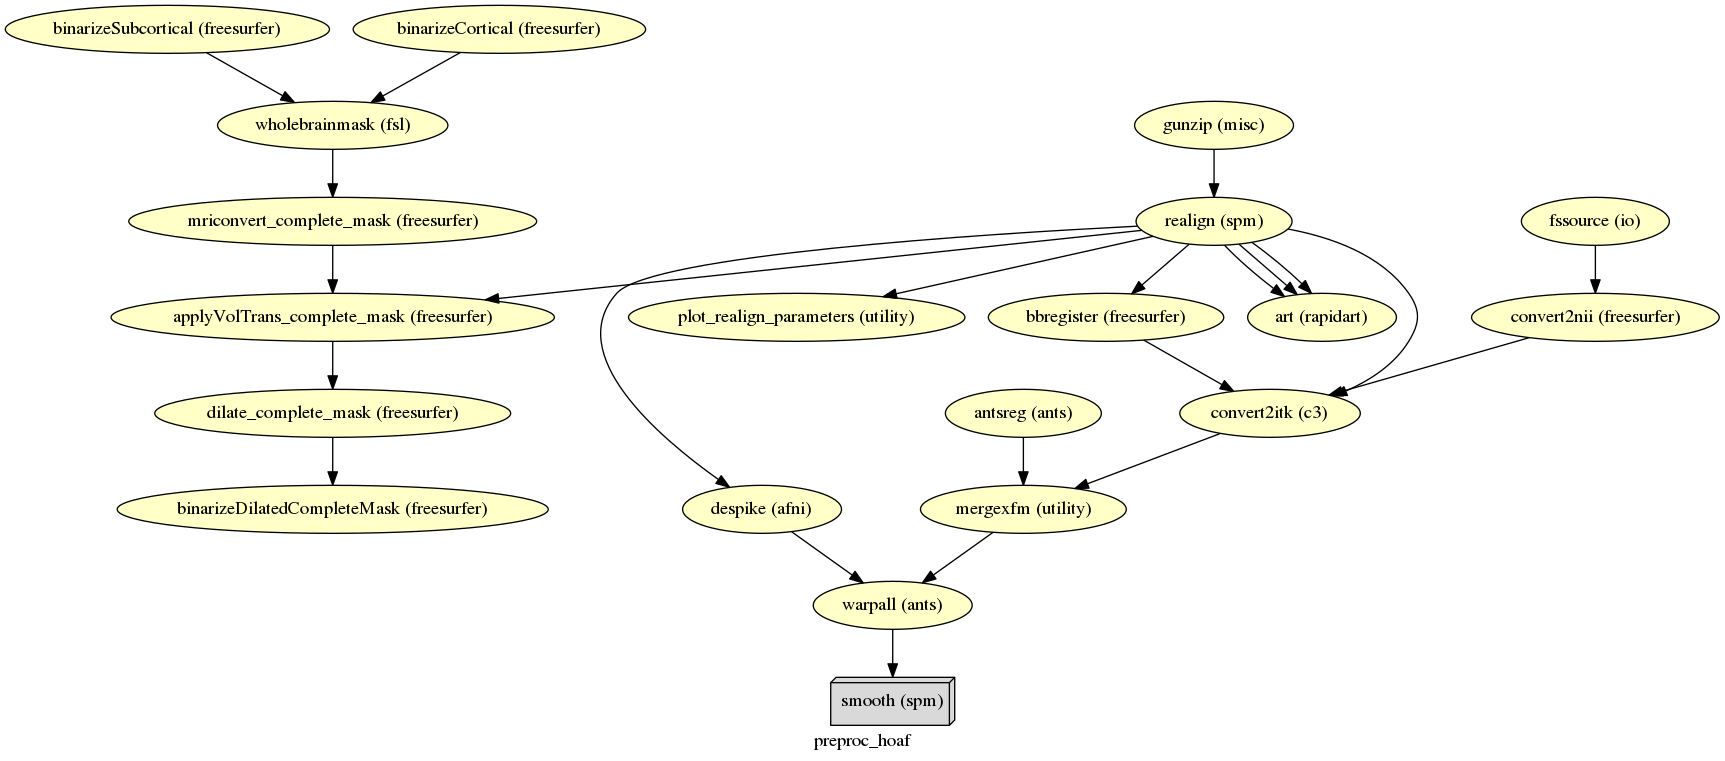

In [13]:
from IPython.display import Image
Image(filename='/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing_sub01/working_dir/preproc_hoaf/graph.png', width=750)

In [14]:
# run the workflow
preproc_hoaf.run('MultiProc', plugin_args={'n_procs': 4})

180726-16:19:25,836 nipype.workflow INFO:
	 Workflow preproc_hoaf settings: ['check', 'execution', 'logging', 'monitoring']
180726-16:19:25,879 nipype.workflow INFO:
	 Running in parallel.
180726-16:19:25,882 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 28.21/28.21, Free processors: 4/4.
180726-16:19:25,954 nipype.workflow INFO:
	 [Node] Setting-up "preproc_hoaf.fssource" in "/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing/working_dir/preproc_hoaf/_subject_id_sub-01/fssource".
180726-16:19:25,954 nipype.workflow INFO:
	 [Node] Setting-up "preproc_hoaf.selectfiles" in "/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing/working_dir/preproc_hoaf/_subject_id_sub-01/selectfiles".
180726-16:19:25,963 nipype.workflow INFO:
	 [Node] Running "fssource" ("nipype.interfaces.io.FreeSurferSource")
180726-16:19:25,963 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
180726-16:1

/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


180726-16:22:43,129 nipype.workflow INFO:
	 [Node] Finished "preproc_hoaf.applyVolTrans_complete_mask".


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


180726-16:22:43,330 nipype.workflow INFO:
	 [Node] Finished "preproc_hoaf.art".
180726-16:22:43,402 nipype.workflow INFO:
	 [Node] Finished "preproc_hoaf.plot_realign_parameters".
180726-16:22:44,70 nipype.workflow INFO:
	 [Job 7] Completed (preproc_hoaf.applyVolTrans_complete_mask).
180726-16:22:44,71 nipype.workflow INFO:
	 [Job 10] Completed (preproc_hoaf.plot_realign_parameters).
180726-16:22:44,73 nipype.workflow INFO:
	 [Job 15] Completed (preproc_hoaf.art).
180726-16:22:44,75 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 3 jobs ready. Free memory (GB): 28.01/28.21, Free processors: 3/4.
                     Currently running:
                       * preproc_hoaf.bbregister
180726-16:22:44,138 nipype.workflow INFO:
	 [Node] Setting-up "preproc_hoaf.dilate_complete_mask" in "/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing/working_dir/preproc_hoaf/_subject_id_sub-01/dilate_complete_mask".
180726-16:22:44,140 nipype.workflow INFO:
	 [Node] Setting-up

	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
180726-16:26:08,335 nipype.interface INFO:
	 sub: /media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing/output_dir/masks/_subject_id_sub-01/dilated_complete_mask.nii -> /media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing/output_dir/masks/sub-sub-01/dilated_complete_mask.nii
180726-16:26:08,338 nipype.interface INFO:
	 sub: /media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing/output_dir/bbregister/_subject_id_sub-01/meansub-01_task-stress_run-1_bold_bbreg_sub-01.dat -> /media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing/output_dir/bbregister/sub-sub-01/meansub-01_task-stress_run-1_bold_bbreg_sub-01.dat
180726-16:26:08,341 nipype.interface INFO:
	 sub: /media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing/output_dir/bbregister/_subject_id_sub-01/meansub-01_task-stress_run-1_bold_bbreg_sub-01.mat -> /media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivat